# Question 3 - Human Nail Condition Classification
Name: Johanes Cedrick Wijaya (2702213801)

### A. Analyze the provided dataset & state the discovered issues! Handle them accordingly!

#### A.1 Import Data and Overview

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc


import os
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

SEED_VALUE = 1234
np.random.seed(SEED_VALUE)
import random
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [2]:
DATASET_PATH = '3B/train'

In [3]:
exts = {".jpg", ".jpeg", ".png"}
sizes = {}
for cls in os.listdir(DATASET_PATH):
    cls_path = os.path.join(DATASET_PATH, cls)
    if not os.path.isdir(cls_path):
        continue
    for fname in os.listdir(cls_path):
        fpath = os.path.join(cls_path, fname)
        if os.path.splitext(fname)[1].lower() in exts:
            try:
                with Image.open(fpath) as im:
                    sizes[(im.width, im.height)] = sizes.get((im.width, im.height), 0) + 1
            except:
                pass
print("Width and height unique sizes and their counts:")
for (w,h), c in sorted(sizes.items(), key=lambda x: (-x[1], x[0])):
    print(f"{(w,h)} -> {c} file")

Width and height unique sizes and their counts:
(416, 416) -> 1766 file


Sebelum kita mengolah data gambar, kita perlu melihat distribusi Width dan Height pada setiap gambar dalam dataset. Pada dataset ini, semua gambar memiliki size 416x416 Pixels

In [4]:
class_counts = {}
exts = {".jpg", ".jpeg", ".png"}

for cls in os.listdir(DATASET_PATH):
    cls_path = os.path.join(DATASET_PATH, cls)
    if not os.path.isdir(cls_path):
        continue
    count = sum(1 for fname in os.listdir(cls_path)
                if os.path.splitext(fname)[1].lower() in exts)
    class_counts[cls] = count

print("Images per class:")
for cls, count in sorted(class_counts.items()):
    print(f"{cls}: {count} images")

print(f"\nTotal images: {sum(class_counts.values())}")

Images per class:
Acral_Lentiginous_Melanoma: 17 images
Healthy_Nail: 275 images
Onychogryphosis: 480 images
blue_finger: 490 images
pitting: 504 images

Total images: 1766


In [ ]:
# import os
# import random
# import shutil

# DATASET_PATH = "3B/train"  
# OUTPUT_TEST_PATH = "3B/test"  
# TEST_RATIO = 0.2 

# exts = {".jpg", ".jpeg", ".png"}

# os.makedirs(OUTPUT_TEST_PATH, exist_ok=True)

# for cls in os.listdir(DATASET_PATH):
#     cls_path = os.path.join(DATASET_PATH, cls)
#     if not os.path.isdir(cls_path):
#         continue
    
#     test_cls_path = os.path.join(OUTPUT_TEST_PATH, cls)
#     os.makedirs(test_cls_path, exist_ok=True)
    
#     files = [f for f in os.listdir(cls_path) if os.path.splitext(f)[1].lower() in exts]
    
#     n_test = int(len(files) * TEST_RATIO)
#     test_files = random.sample(files, n_test)
    
#     for fname in test_files:
#         src = os.path.join(cls_path, fname)
#         dst = os.path.join(test_cls_path, fname)
#         shutil.move(src, dst) 
    
#     print(f"Kelas '{cls}': {n_test} file dipindahkan ke test folder")

Untuk menjaga data test tidak bocor selama training, saya memilih untuk memisahkan dahulu data test, diambil sebanyak 0.2 dan disimpan pada folder test

In [6]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.1,
    label_mode='categorical',
    subset='training',
    seed=SEED_VALUE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.1,
    label_mode='categorical',
    subset='validation',
    seed=SEED_VALUE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "3B/test",
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False 
)

Found 1766 files belonging to 5 classes.
Using 1590 files for training.
Found 1766 files belonging to 5 classes.
Using 176 files for validation.
Found 439 files belonging to 5 classes.


In [7]:
train_ds.class_names

['Acral_Lentiginous_Melanoma',
 'Healthy_Nail',
 'Onychogryphosis',
 'blue_finger',
 'pitting']

In [8]:
class_names = train_ds.class_names

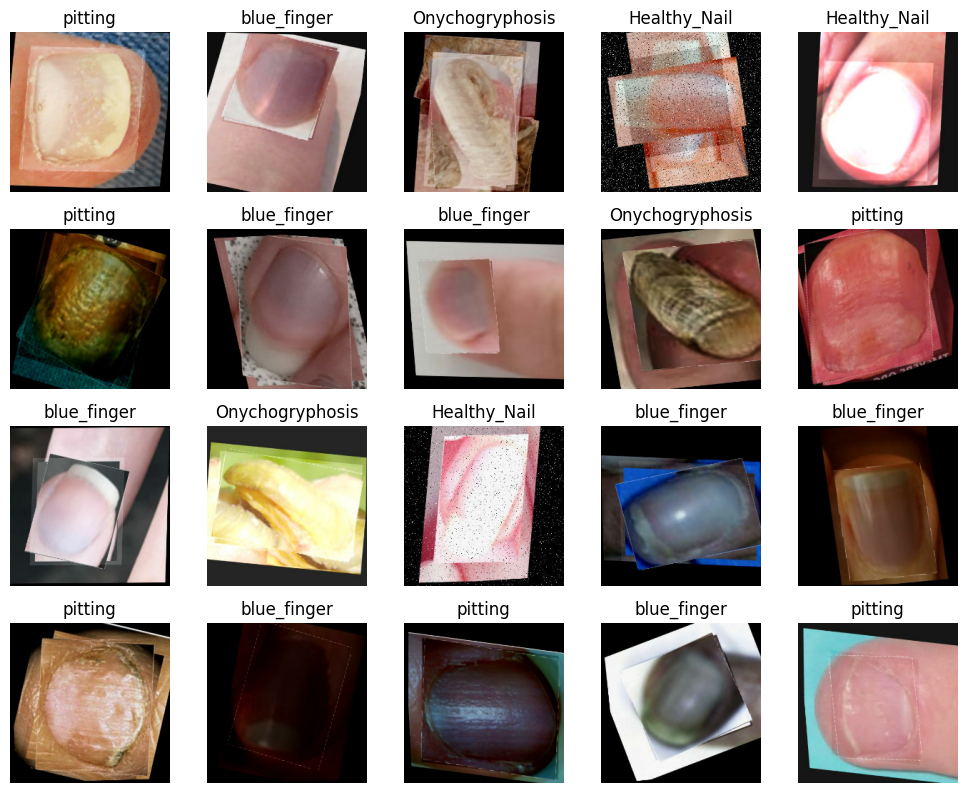

In [9]:
plt.figure(figsize=(10, 10)) 

for images, labels in train_ds.take(1): 
    
    for i in range(20):
        if i >= len(images):
            break
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_index = int(np.argmax(labels[i].numpy()).astype("uint8"))
        plt.title(train_ds.class_names[class_index])
        plt.axis("off")
plt.tight_layout()
plt.show()

Ketika kita melihat beberapa data, nampaknya gambar kuku yang dimiliki dataset telah di manipulasi/edit/augmentasi. Bisa dilihat pada gambar, terdapat beberapa gambar yang terlihat seperti terbalik, ataupun seperti memiliki tumpukan layer pada gambarnya. Dari gambar-gambar di atas juga dapat dilihat bahwa gambar sangat bervariasi, dan memiliki karakteristik yang berbeda.

Findings:
- Terdapat anomali yang nanti harus dihandle dengan baik, yaitu class imbalance. kelas 0 atau Acral_Lentiginous_Melanoma hanya memiliki 21 data di dalamnya dan hal ini dapat menyebabkan model tidak dapat mempelajari kelas tersebut dan pada akhirnya tidak dapat mengklasifikasikan kelas minoritas tersebut
- Data sudah memiliki ukuran yang sama yaitu 416x416
- Jumlah dataset kecil, mungkin dapat menyebabkan overfitting

### B. Construct the baseline architecture according to the figure below. Use ReLU as the activation function of each hidden layer. Train the model for at least 20 epochs & analyze the trainvalidation loss plot!

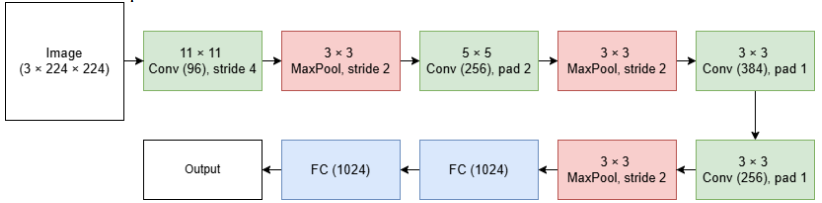

#### B.1 Data Augmentation

In [10]:
train_ds = train_ds.cache()

In [11]:
train_ds = train_ds.shuffle(1000)

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.05, 0.05),
], name="data_augmentation")

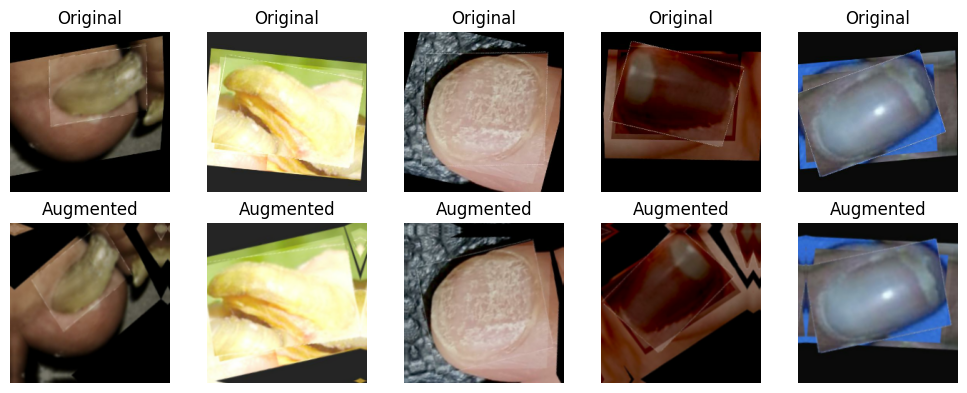

In [13]:
for images, labels in train_ds.take(1):
    sample_images = images[:5]
    augmented_images = data_augmentation(sample_images, training=True)
    break

# Tampilkan sebelum dan sesudah augmentasi
plt.figure(figsize=(10, 4))
for i in range(5):
    # Gambar asli
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i].numpy().astype("uint8"))
    plt.title("Original")
    plt.axis("off")
    
    # Gambar setelah augmentasi
    plt.subplot(2, 5, i + 6)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title("Augmented")
    plt.axis("off")

plt.tight_layout()
plt.show()

Ini merupakan contoh hasil data train yang di augmentasi

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

hanya augmentasi data train saja, tidak disarankan untuk mengaugmentasi data validasi

In [15]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [16]:
def test_model(model, test_data):
    y_true, y_pred = [], []

    for images, labels in test_data:
        probs = model.predict(images, verbose=0)
        preds = np.argmax(probs, axis=1)
        true_labels = np.argmax(labels.numpy(), axis=1)

        y_pred.extend(preds.tolist())
        y_true.extend(true_labels.tolist())
        
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

    return y_pred, y_true

#### B.2 Model 1 Training

In [17]:
model_1 = Sequential([
    layers.Conv2D(96, (11,11), strides=4, activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((3,3), strides=2),
    layers.Conv2D(256, (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D((3,3), strides=2),
    layers.Conv2D(384, (3,3), padding='same', activation='relu'),
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((3,3), strides=2),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(5, activation='softmax')
])

c:\Users\johan\Bina Nusantara\Semester 5\Deep Learning\Code\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC()]
)

In [19]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     6,554,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,029,061 (38.26 MB)

 Trainable params: 10,029,061 (38.26 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history_model1 = model_1.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20,
    verbose = 1,
)
print("Validation metrics:", model_1.evaluate(val_ds, verbose=0))

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 239ms/step - accuracy: 0.3591 - auc: 0.6657 - loss: 4.3076 - val_accuracy: 0.4148 - val_auc: 0.7899 - val_loss: 1.2435
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 236ms/step - accuracy: 0.5384 - auc: 0.8376 - loss: 1.1187 - val_accuracy: 0.5966 - val_auc: 0.8502 - val_loss: 1.0974
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 233ms/step - accuracy: 0.5748 - auc: 0.8618 - loss: 1.0397 - val_accuracy: 0.6989 - val_auc: 0.9111 - val_loss: 0.8430
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 235ms/step - accuracy: 0.6447 - auc: 0.8983 - loss: 0.9010 - val_accuracy: 0.6818 - val_auc: 0.9025 - val_loss: 0.8862
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 243ms/step - accuracy: 0.6497 - auc: 0.9045 - loss: 0.8691 - val_accuracy: 0.6818 - val_auc: 0.9056 - val_loss: 0.8880
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 240ms/step - accuracy: 0.6805 - auc: 0.9144 - loss: 0.8220 - val_accuracy: 0.7386 - val_auc: 0.9342 - val_loss: 0.7270
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━

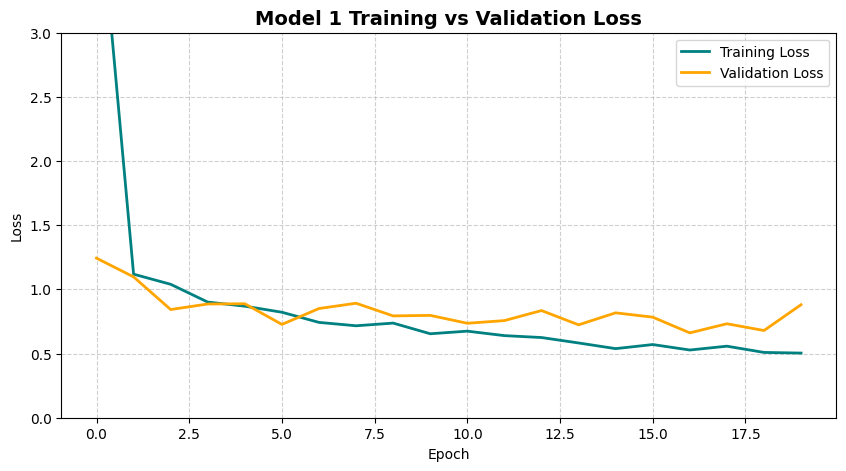

In [62]:
plt.figure(figsize=(10,5))
plt.plot(history_model1.history['loss'], label='Training Loss', color='teal', linewidth=2)
plt.plot(history_model1.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title('Model 1 Training vs Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 3.0)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [65]:
avg_train_loss = np.mean(history_model1.history['loss'])
avg_val_loss = np.mean(history_model1.history['val_loss'])
print(f"Average Training Loss: {avg_train_loss:.4f}")
print(f"Average Validation Loss: {avg_val_loss:.4f}")

Average Training Loss: 0.8818
Average Validation Loss: 0.8313


Dengan menggunakan model pertama, yaitu arsitektur yang diberikan dari soal, model mendapatkan hasil yang cukup baik, dengan training loss 0.88 dan validation loss 0.83. Ketika melihat pada grafik di atas, kita dapat melihat bahwa pada epoch 10 sampai pada epoch 20, model mulai mengalami overfitting, dimana validation loss mulai meningkat, sedangkan training loss menurun. Ini menandakan bahwa model mulai menghafal data training dan tidak generalize ke data baru. Berdasarkan analisa saya, hal ini dapat terjadi akibat arsitektur CNN yang tidak memiliki layer dropout untuk menonaktifkan neuron pada fully connected layer sampai ke layer output. Hal ini dapat menyebabkan semua bobot diperbarui saat backpropagation dan model jadi terlalu menghafal data training. 

### C. Modify the model and analyze the impact of your modification on the model’s validation results! The modification may include changes in the model’s architecture (e.g. changing the layers, adding Batch Normalizations, etc.) or fine-tuning it.

#### C.1 Add Class Weight

In [24]:
class_counts = {}
for class_name in os.listdir(DATASET_PATH):
    class_path = os.path.join(DATASET_PATH, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith((".jpg",".png",".jpeg"))])
        class_counts[class_name] = count

class_counts

{'Acral_Lentiginous_Melanoma': 17,
 'blue_finger': 490,
 'Healthy_Nail': 275,
 'Onychogryphosis': 480,
 'pitting': 504}

In [25]:
counts_ordered = [class_counts[name] for name in class_names]
print("Ordered counts:", counts_ordered)

Ordered counts: [17, 275, 480, 490, 504]


In [26]:
# total = sum(counts_ordered)
# num_classes = len(counts_ordered)

# class_weights = {
#     i: total / (num_classes * counts_ordered[i])
#     for i in range(num_classes)
# }
# print(class_weights)

In [27]:
# counts = np.array(counts_ordered, dtype=np.float64)
# beta = 0.99
# eff_num = 1.0 - np.power(beta, counts)
# w = (1.0 - beta) / np.maximum(eff_num, 1e-8)

# N = counts.sum()
# avg = (w * counts).sum() / N
# w /= avg

# class_weights_norm = {i: float(w[i]) for i in range(len(w))}
# print(class_weights_norm)

In [28]:
class_weights_manual = {
    0: 5.0,
    1: 0.99,
    2: 0.94,
    3: 0.94,
    4: 0.94
}

Sebelumnya saya mendapatkan class weights dengan score 20 untuk class 0, dan ketika dicoba pada model, menghasilkan punishment yang terlalu besar sehingga model jadi terlalu sering untuk menebak kelas minnoritas. Jadi saya mencoba untuk menggunakan class weigth manual yang sebelumnya telah dihitung menggunakan Class Balanced Loss Weighting. 

#### C.2 Model 2 Training

In [84]:
model_2 = Sequential([
    layers.Conv2D(96, (11,11), strides=4, activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((3,3), strides=(2,2)),
    
    layers.Conv2D(256, (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D((3,3), strides=(2,2)),
    
    layers.Conv2D(384, (3,3), padding='same', activation='relu', strides=1),
    layers.Conv2D(384, (3,3), padding='same', activation='relu', strides=1),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', strides=1),

    layers.MaxPooling2D((3,3), strides=(2,2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(5, activation='softmax')
])

Pada Model yang kedua, saya tidak merubah banyak pada arsitekturnya, melainkan saya hanya memodifikasi beberapa hal, seperti strides, menambahkan layer convolution, dan juga menambahkan dropout untuk mencegah overfitting pada model

In [85]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC()]
)

In [86]:
model_2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)              │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,065,093 (19.32 MB)

 Trainable params: 5,065,093 (19.32 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
history_model2 = model_2.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20,
    class_weight=class_weights_manual,
    verbose = 1,
)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.3371 - auc_7: 0.6702 - loss: 1.6728 - val_accuracy: 0.4830 - val_auc_7: 0.7895 - val_loss: 1.2771
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.3780 - auc_7: 0.7309 - loss: 1.4098 - val_accuracy: 0.4205 - val_auc_7: 0.7583 - val_loss: 1.3186
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.4679 - auc_7: 0.7808 - loss: 1.3235 - val_accuracy: 0.5795 - val_auc_7: 0.8485 - val_loss: 1.1143
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.4516 - auc_7: 0.7827 - loss: 1.3198 - val_accuracy: 0.5682 - val_auc_7: 0.8566 - val_loss: 1.1653
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.5107 - auc_7: 0.8203 - loss: 1.2237 - val_accuracy: 0.5568 - val_auc_7: 0.8435 - val_loss: 1.0845
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.5371 - auc_7: 0.8277 - loss: 1.1892 - val_accuracy: 0.5000 - val_auc_7: 0.8196 - val_loss: 1.1992
Epoch 7/20

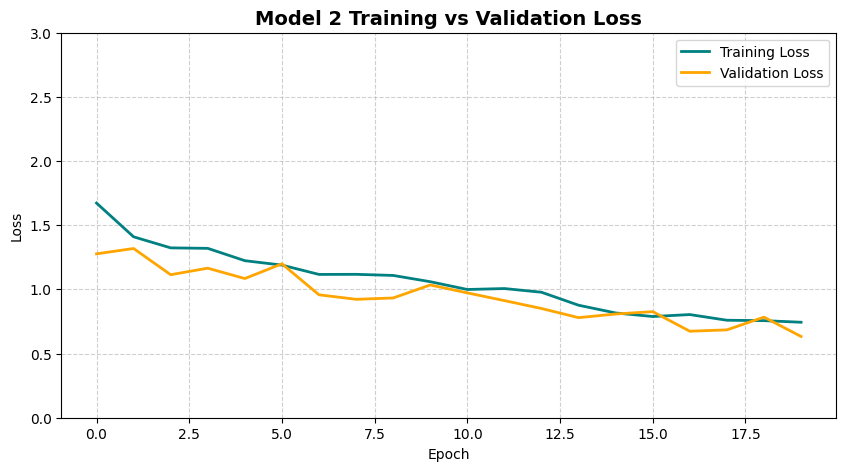

In [89]:
plt.figure(figsize=(10,5))
plt.plot(history_model2.history['loss'], label='Training Loss', color='teal', linewidth=2)
plt.plot(history_model2.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title('Model 2 Training vs Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 3.0)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [93]:
avg_train_loss_model2 = np.mean(history_model2.history['loss'])
avg_val_loss_model2 = np.mean(history_model2.history['val_loss'])
print(f"Average Training Loss: {avg_train_loss_model2:.4f}")
print(f"Average Validation Loss: {avg_val_loss_model2:.4f}")

Average Training Loss: 1.0535
Average Validation Loss: 0.9467


Pada model kedua ini, model memiliki nilai loss yang sedikit lebih tinggi dibandingkan dengan model sebelumnya. Namun jika melihat grafik dari training loss dan validation loss, overfitting dapat teratasi dengan baik. Dengan menambahkan layer dropout, model dapat lebih generalize dan tidak menghafal data training berlebihan. Sebelumnya saya mencoba 25 epochs, namun ketika sudah melewati 20 epoch, mulai terjadi fluktuasi dan model mulai mengalami overfitting kembali. Maka dari itu, saya tetap menggunakan 20 epochs pada model kedua ini. Untuk analisis lebih lanjut kita dapat melihat pada test model di bagian E

### D. Perform Transfer Learning using a pre-trained CNN model! Analyze how it performs compared to the other 2 models on the validation set!


#### D.1 ResNet50

In [37]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

Pretrained model yang saya gunakan pada model ketiga ini adalah ResNet50. ResNet50 adalah pretrained model yang dilatih di ImageNet dengan lebih dari 1000 kelas, model pretrained ini memiliki kemampuan yang sangat baik dalam klasifikasi images. Pada model ketiga ini, saya menggabungkan custom cnn dengan base model ResNet50, dengan tujuan menangkap pola yang kompleks dan memberikan model dengan akurasi yang tinggi

In [39]:
resnet_model = Sequential([
    layers.Lambda(preprocess_input, name="resnet_preproc"),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(5, activation="softmax"),
], name="resnet50_tl")

In [40]:
resnet_model.build(input_shape=(None, 224, 224, 3))

In [41]:
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC()]
)

In [42]:
resnet_model.summary()

Model: "resnet50_tl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet_preproc (Lambda)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [43]:
resnet_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, min_lr=1e-5),
]

In [44]:
history_resnet = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=resnet_callbacks,
    verbose=1,
    class_weight=class_weights_manual
)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 599ms/step - accuracy: 0.4811 - auc_2: 0.7866 - loss: 1.4767 - val_accuracy: 0.7500 - val_auc_2: 0.9475 - val_loss: 0.7177 - learning_rate: 1.0000e-04
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 536ms/step - accuracy: 0.6667 - auc_2: 0.9127 - loss: 0.8829 - val_accuracy: 0.8125 - val_auc_2: 0.9708 - val_loss: 0.5402 - learning_rate: 1.0000e-04
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 526ms/step - accuracy: 0.7629 - auc_2: 0.9488 - loss: 0.6995 - val_accuracy: 0.8466 - val_auc_2: 0.9790 - val_loss: 0.4438 - learning_rate: 1.0000e-04
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 524ms/step - accuracy: 0.8075 - auc_2: 0.9641 - loss: 0.5915 - val_accuracy: 0.8523 - val_auc_2: 0.9794 - val_loss: 0.4115 - learning_rate: 1.0000e-04
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 522ms/step - accuracy: 0.8239 - auc_2: 0.9705 - loss: 0.5266 - val_accuracy: 0.8636 - val_auc_2: 0.9837 - val_loss: 0.3605 - learning_rate: 1.0000e-04
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━

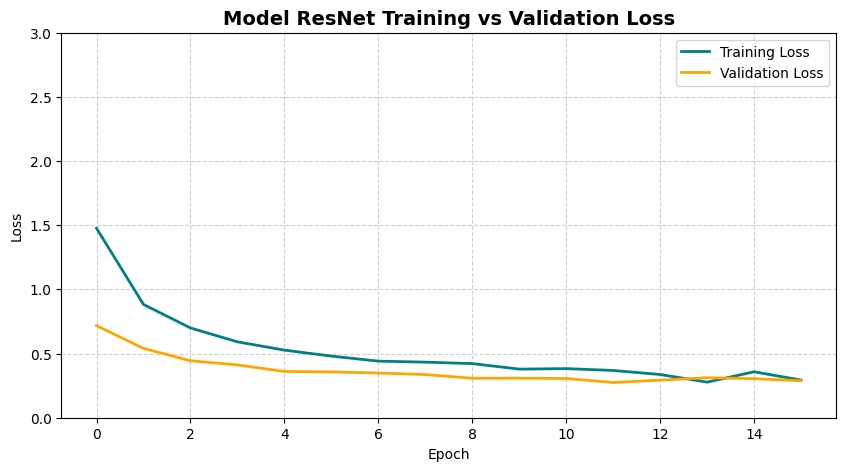

In [94]:
plt.figure(figsize=(10,5))
plt.plot(history_resnet.history['loss'], label='Training Loss', color='teal', linewidth=2)
plt.plot(history_resnet.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title('Model ResNet Training vs Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 3.0)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [96]:
avg_train_loss_resnet = np.mean(history_resnet.history['loss'])
avg_val_loss_resnet = np.mean(history_resnet.history['val_loss'])
print(f"Average Training Loss: {avg_train_loss_resnet:.4f}")
print(f"Average Validation Loss: {avg_val_loss_resnet:.4f}")

Average Training Loss: 0.5218
Average Validation Loss: 0.3692


Dengan menggunakan Transfer Learning, kita dapat melihat bahwa perbedaan yang terjadi sangat signifikan, yaitu loss turun sampai ke angka 0.3. Ini membuktikan bahwa Pretrained Model ResNet dengan CNN sangat efektif dalam melakukan image classification. Penggunaan dropout juga mencegah model untuk overfit. Dengan melihat grafik di atas, dapat dikatakan bahwa loss semakin konvergen, dan model belajar dengan sangat baik. Tidak terjadi overfitting, dan mari kita lihat hasilnya pada data test

### E. Analyze how each model performs on the test set using at least 3 key metrics. Interpret the meaning of the metrics & make a conclusion!


#### E.1 Model 1

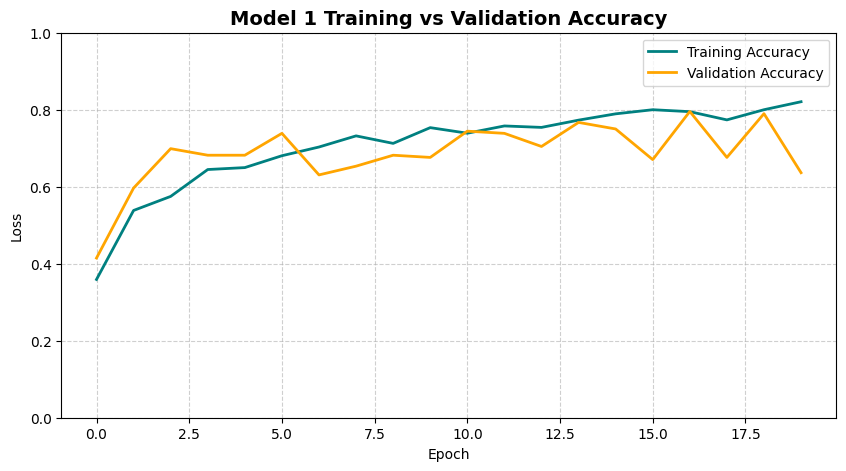

In [92]:
plt.figure(figsize=(10,5))
plt.plot(history_model1.history['accuracy'], label='Training Accuracy', color='teal', linewidth=2)
plt.plot(history_model1.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
plt.title('Model 1 Training vs Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

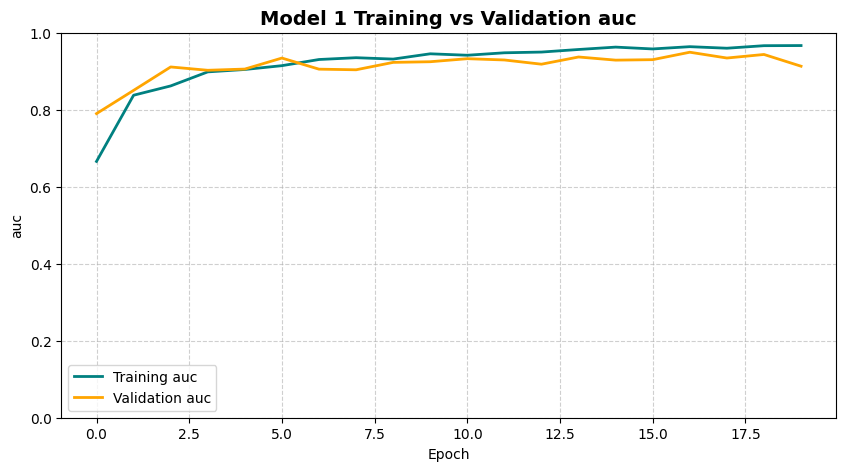

In [104]:
plt.figure(figsize=(10,5))
plt.plot(history_model1.history['auc'], label='Training auc', color='teal', linewidth=2)
plt.plot(history_model1.history['val_auc'], label='Validation auc', color='orange', linewidth=2)
plt.title('Model 1 Training vs Validation auc', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('auc')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

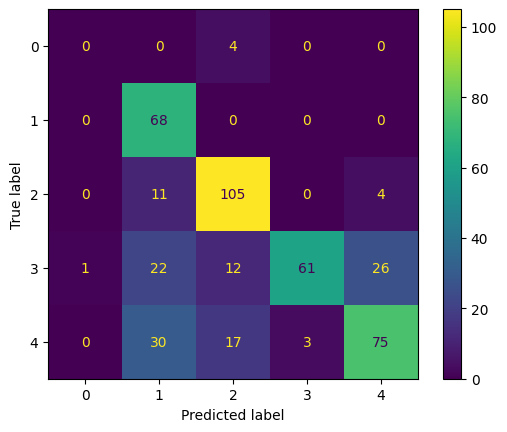

In [48]:
y_pred_model1, y_true = test_model(model_1, test_ds)

In [49]:
print(classification_report(y_true, y_pred_model1, target_names=test_ds.class_names))

                            precision    recall  f1-score   support

Acral_Lentiginous_Melanoma       0.00      0.00      0.00         4
              Healthy_Nail       0.52      1.00      0.68        68
           Onychogryphosis       0.76      0.88      0.81       120
               blue_finger       0.95      0.50      0.66       122
                   pitting       0.71      0.60      0.65       125

                  accuracy                           0.70       439
                 macro avg       0.59      0.59      0.56       439
              weighted avg       0.76      0.70      0.70       439



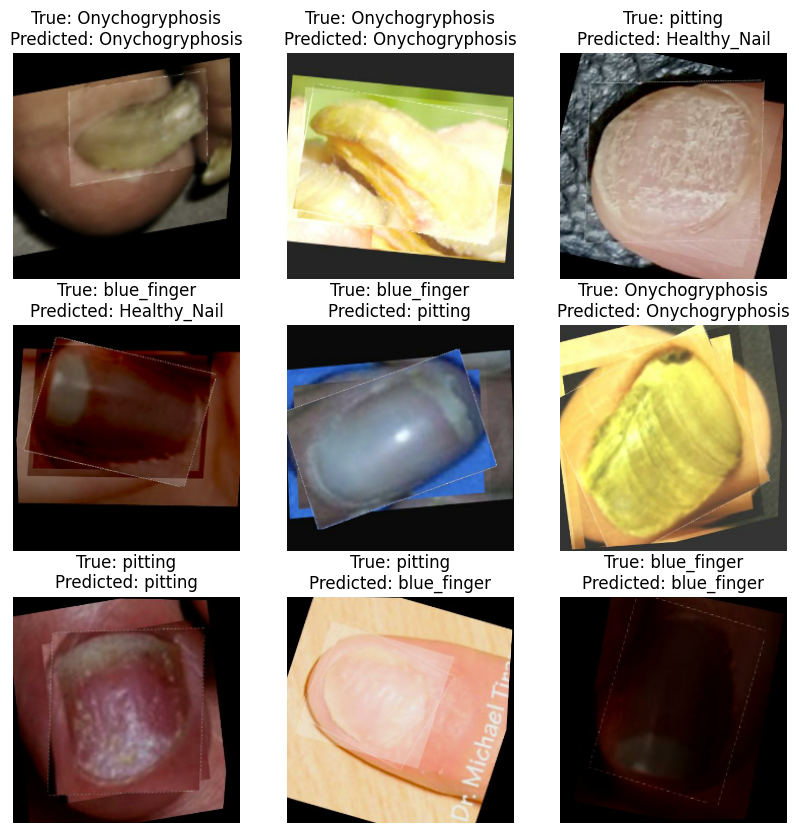

In [114]:
plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3,3,i+1)
    image = images[i].numpy()
    true_label = np.argmax(labels[i].numpy())
    
    probs = model_1.predict(np.expand_dims(image, axis=0), verbose=0)
    pred_class = np.argmax(probs, axis=1)[0]

    plt.imshow(image.astype("uint8"))
    plt.title(f"True: {class_names[true_label]}\nPredicted: {class_names[pred_class]}")
    plt.axis("off")

plt.show()

Berdasarkan metrics yang kita lihat di atas, dapat dilihat bahwa performa dari model 1, tidak seperti yang diharapkan ketika melihat training loss. Walaupun training lossnya terlihat menurun, namun ternyata itu menunjukkan gejala overfitting, dimana ketika diuji dengan data yang baru dan belum pernah dilihat, model menjadi kurang akurat. Ketika kita melihat hasil dari confusion matrixnya, kita juga melihat bahwa model juga masih belum berani untuk menebak kelas minoritas.

Performance
- Accuracy: Accuracy hanyalah metric yang mengukur persentase model benar menebak. ketika training, dapat dilihat bahwa persentase accuracy menurun cukup banyak ketika diuji pada data test. Hal ini menunjukkan overfitting
- Precision: Artinya adalah mengukur keakuratan model ketika memprediksi positif. Contohnya, pada kelas blue finger kita mendapatkan precision 0.95, artinya adalah dari semua prediksi positif yang kita buat, 95% nya betul 
- Recall: Recall adalah mengukur seberapa banyak kasus positif yang berhasil diprediksi oleh model. Contohnya pada blue finger, kita mendapatkan recall yang rendah, yaitu 0.50. Artinya model hanya berhasil menangkap 50% dari semua kasus positif pada label itu.
- F1-Score: F1 score adalah harmonic mean antara precision dan recall, yang biasanya digunakan untuk lebih menggambarkan keseluruhan performance. Contohnya pada Onychogryphosis mendapatkan F1 score sebesar 0.81, artinya model memiliki keseimbangan yang cukup baik antara precision dan recall
- AUC: AUC mengukur seberapa baik performa model dalam memisahkan kelas positif dan negatif secara menyeluruh. semakin mendekati 1 maka semakin baik. Pada graph dapat dilihat bahwa AUC memiliki hasil yang cukup baik yaitu 0.8-0.9 sampai pada akhir epoch 

Analisis
- Model mengalami overfitting, sehingga banyak menebak kelas yang mayoritas, contohnya adalah model sering menebak kelas 1 atau healthy nail
- Hal ini mungkin dikarenakan model tidak memiiki layer dropout
- Model tidak berani untuk menebak kelas minoritas
- Perlu tuning pada model agar achieve hasil lebih baik, karena pada data medis, F1-Score 0.56 juga masih tegolong rendah
- Kita perlu memperhatikan recall, dimana data medis lebih mengutamakan recall. Karena lebih penting kita bisa menangkap pasien yang benar-benar memiliki penyakit kuku, daripada terlewat.

#### E.2 Model 2

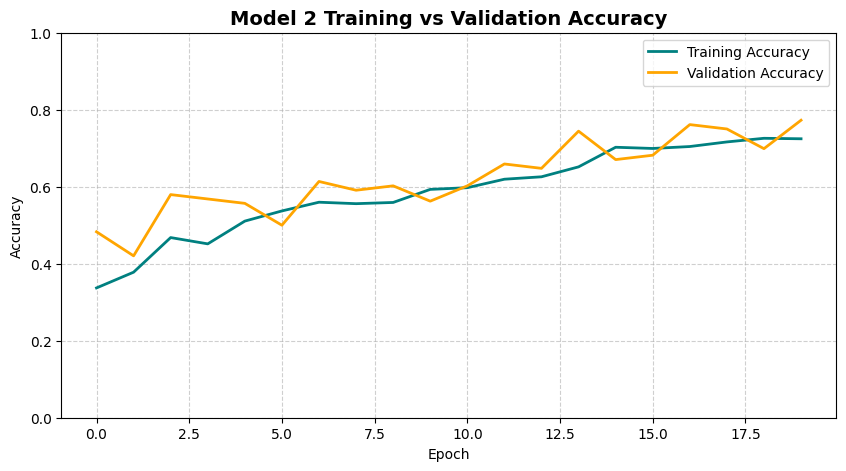

In [101]:
plt.figure(figsize=(10,5))
plt.plot(history_model2.history['accuracy'], label='Training Accuracy', color='teal', linewidth=2)
plt.plot(history_model2.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
plt.title('Model 2 Training vs Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

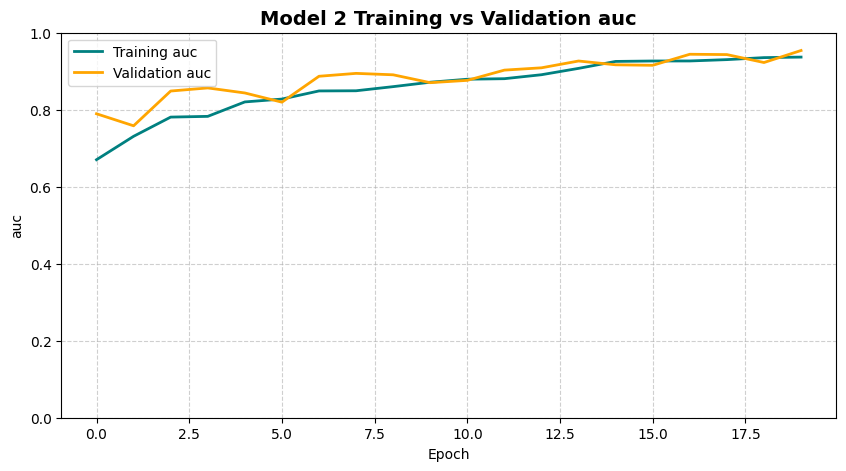

In [106]:
plt.figure(figsize=(10,5))
plt.plot(history_model2.history['auc_7'], label='Training auc', color='teal', linewidth=2)
plt.plot(history_model2.history['val_auc_7'], label='Validation auc', color='orange', linewidth=2)
plt.title('Model 2 Training vs Validation auc', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('auc')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

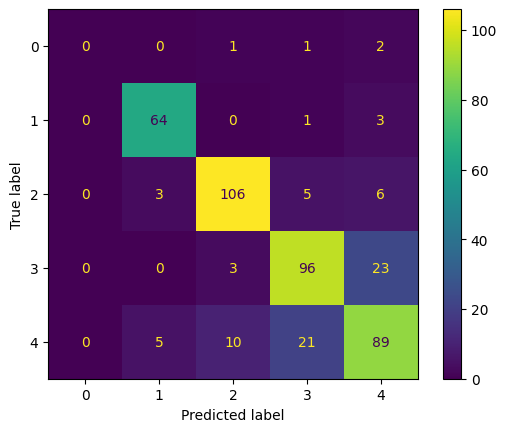

In [90]:
y_pred_model2, y_true = test_model(model_2, test_ds)

In [91]:
print(classification_report(y_true, y_pred_model2, target_names=test_ds.class_names)) 

                            precision    recall  f1-score   support

Acral_Lentiginous_Melanoma       0.00      0.00      0.00         4
              Healthy_Nail       0.89      0.94      0.91        68
           Onychogryphosis       0.88      0.88      0.88       120
               blue_finger       0.77      0.79      0.78       122
                   pitting       0.72      0.71      0.72       125

                  accuracy                           0.81       439
                 macro avg       0.65      0.66      0.66       439
              weighted avg       0.80      0.81      0.80       439



c:\Users\johan\Bina Nusantara\Semester 5\Deep Learning\Code\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\johan\Bina Nusantara\Semester 5\Deep Learning\Code\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\johan\Bina Nusantara\Semester 5\Deep Learning\Code\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

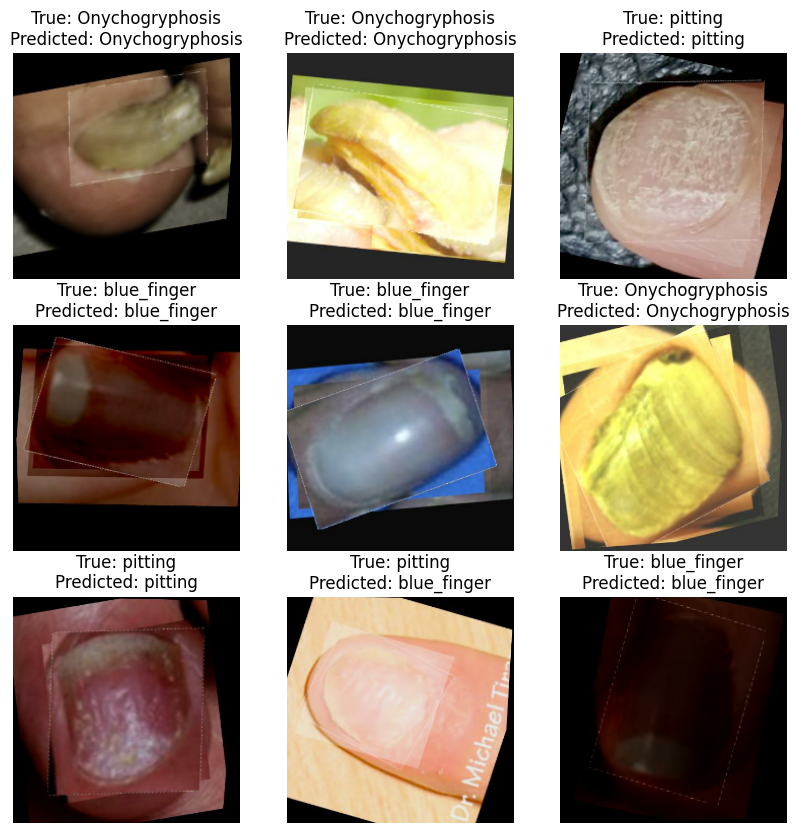

In [115]:
plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3,3,i+1)
    image = images[i].numpy()
    true_label = np.argmax(labels[i].numpy())
    
    probs = model_2.predict(np.expand_dims(image, axis=0), verbose=0)
    pred_class = np.argmax(probs, axis=1)[0]

    plt.imshow(image.astype("uint8"))
    plt.title(f"True: {class_names[true_label]}\nPredicted: {class_names[pred_class]}")
    plt.axis("off")

plt.show()

Berdasarkan model kedua, dapat dilihat bahwa model memiliki peningkatan dari model sebelumnya: dimana model sudah tidak terlalu dominan kepada satu kelas. ini artinya overfitting telah berhasil di atasi, namun belum sepenuhnya. Model kedua masih belum mampu untuk menebak kelas minoritas yaitu kelas 0, bahkan model tidak menebak sama sekali kelas 0 tersebut. Ini bisa disebabkan karena data memang sedikit, model belum dapat menangkap pola kompleks pada kelas tersebut, atau bisa juga punishment dengan class_weight yang kurang besar pada kelas 0. Berdasarkan analisis saya, model kedua ini lebih robust dan generalize terhadap data baru, dapat dilihat ketika kita uji dengan data yang belum pernah dilihat, model dapat achieve score accuracy yang lebih tinggi dibandingkan saat training dan validating.

#### E.3 Transfer Learning ResNet50

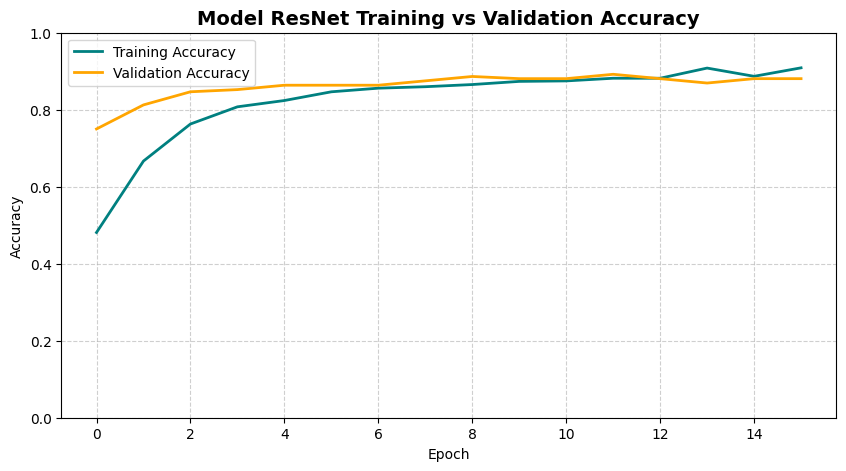

In [109]:
plt.figure(figsize=(10,5))
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy', color='teal', linewidth=2)
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
plt.title('Model ResNet Training vs Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

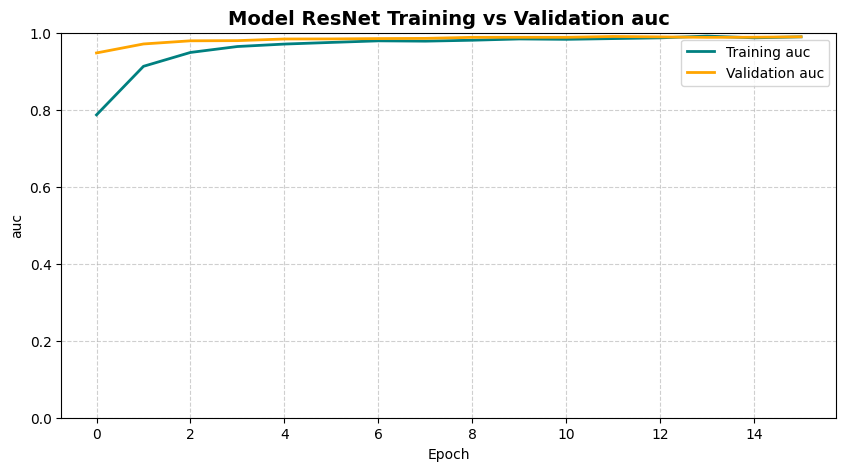

In [110]:
plt.figure(figsize=(10,5))
plt.plot(history_resnet.history['auc_2'], label='Training auc', color='teal', linewidth=2)
plt.plot(history_resnet.history['val_auc_2'], label='Validation auc', color='orange', linewidth=2)
plt.title('Model ResNet Training vs Validation auc', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('auc')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

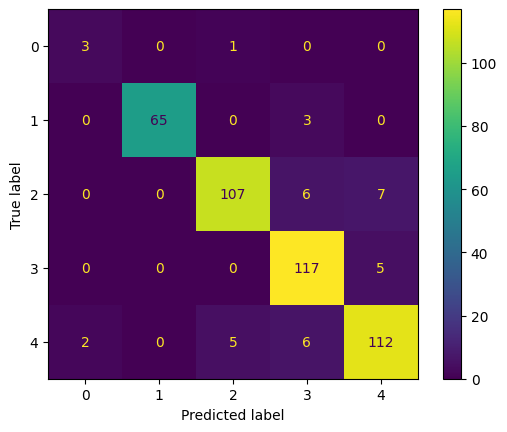

In [56]:
y_pred_resnet, y_true = test_model(resnet_model, test_ds)

In [58]:
print(classification_report(y_true, y_pred_resnet, target_names=test_ds.class_names))

                            precision    recall  f1-score   support

Acral_Lentiginous_Melanoma       0.60      0.75      0.67         4
              Healthy_Nail       1.00      0.96      0.98        68
           Onychogryphosis       0.95      0.89      0.92       120
               blue_finger       0.89      0.96      0.92       122
                   pitting       0.90      0.90      0.90       125

                  accuracy                           0.92       439
                 macro avg       0.87      0.89      0.88       439
              weighted avg       0.92      0.92      0.92       439



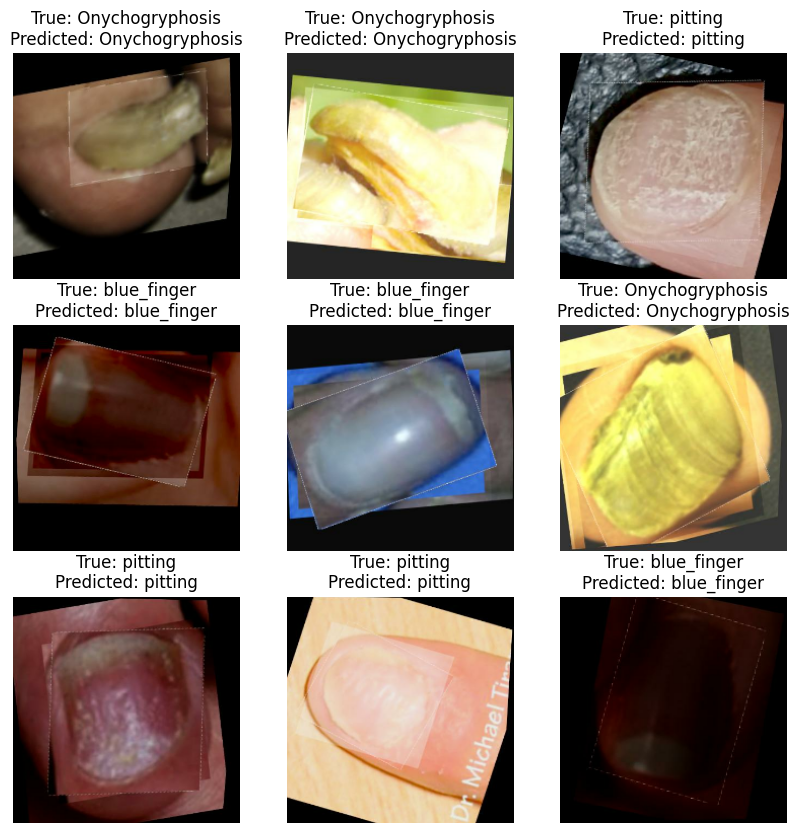

In [116]:
plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3,3,i+1)
    image = images[i].numpy()
    true_label = np.argmax(labels[i].numpy())
    
    probs = resnet_model.predict(np.expand_dims(image, axis=0), verbose=0)
    pred_class = np.argmax(probs, axis=1)[0]

    plt.imshow(image.astype("uint8"))
    plt.title(f"True: {class_names[true_label]}\nPredicted: {class_names[pred_class]}")
    plt.axis("off")

plt.show()

Model ResNet menunjukkan hasil yang terbaik dibandingkan dua model sebelumnya. Model ini juga terlihat berani untuk menebak kelas minoritas, dan berhasil mendapatkan 3 dari 4 kasus pada kelas minoritas, ini yang digambarkan oleh recall 0.75. Model ResNet juga memiliki AUC yang hampir sempurna, yaitu 0.9-1.0, menandakan bahwa model sangat mampu untuk membedakan antar kelas. ROC-AUC memang sering digunakan ketika klasifikasi, karena lebih baik ketika terjadi kasus imbalance class. Karena jika kelas imbalance dan model memprediksi kelas minoritas terus menerus, ini menyebabkan akurasi tinggi, namun sebenarnya performanya buruk, karena model tidak mampu membedakan ciri setiap kelas. Dari model ResNet ini juga didapat bahwa model tidak mengalami overfitting dan justru semakin konvergen pada setiap epoch

#### E.4 Conclusion

Dari ketiga model di atas, dan setelah melalui proses training yang panjang, dapat disimpulkan bahwa untuk menangani medical tasks image classification:
- pretrained model jauh lebih unggul dibandingkan dengan custom CNN yang dilatih dari awal. 
- Model yang dilatih dari awal cenderung cepat untuk mengalami overfitting, dan model kurang berani menebak kelas minoritas. 
- Penambahan dropout juga ternyata mengatasi masalah overfitting pada model, dan menyebabkan model menjadi lebih robust dan bisa memprediksi data baru. 
- Class weighting cukup efektif juga ketika terjadi class imbalance, walaupun mungkin bisa di tuning untuk mendapatkan penalty yang terbaik untuk setiap kelas
- Medical images mementingkan model dengan recall yang tinggi, dengan tujuan menangkap kasus positif dengan lebih akurat, dan tidak melewatkan pasien yang ternyata memiliki penyakit

Rekomendasi:
- Hyperparameter tuning untuk model custom CNN, karena berdasarkan analisis saya, model CNN yang custom dapat memiliki hasil yang akurat namun perlu menemukan parameter yang tepat, termasuk tuning class weight, learning rate, dan juga jumlah neuron di layer convolution
- Berdasarkan analisis saya, untuk menangkap pola dari kelas minoritas, perlu ditambahkan data kembali agar model bisa menangkap ciri dan juga pola pada kelas minoritas dengan lebih baik